# Results for ipyrad vs stacks simulated and empirical reference sequence assembly
I'm assuming here that you've already run the de novo assemblies and have already installed all the prereqs for
analysing the results. If not run the ipyrad-manuscript-results.ipynb.

In [185]:
## Imports and working/output directories directories

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
plt.rcParams["figure.figsize"] = [12,9]

from collections import Counter
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import toyplot
import toyplot.html    ## toypot sublib for saving html plots
import pandas as pd
import numpy as np
import collections
import allel
import vcfnp
import shutil
import gzip
import glob
import os
from allel.util import * ## for ensure_square()

WORK_DIR="/home/iovercast/manuscript-analysis/"

## Simulation dirs
REFMAP_SIM_DIR = os.path.join(WORK_DIR, "REFMAP_SIM/")
IPYRAD_SIM_DIR = os.path.join(REFMAP_SIM_DIR, "ipyrad/reference-assembly/")
STACKS_SIM_DIR = os.path.join(REFMAP_SIM_DIR, "stacks/")
## A list of the simluated assembler names for indexing dicts
assemblers = ["ipyrad-reference", "ipyrad-denovo_reference", "stacks"]

## Empirical dirs
REFMAP_EMPIRICAL_DIR=os.path.join(WORK_DIR, "Phocoena_empirical/")
IPYRAD_REFMAP_DIR=os.path.join(REFMAP_EMPIRICAL_DIR, "ipyrad/")
STACKS_REFMAP_DIR=os.path.join(REFMAP_EMPIRICAL_DIR, "stacks/")


# Some helpful functions

## Function for plotting PCA given an input vcf file

In [2]:
def plotPCA(call_data, title):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    sns.despine(ax=ax, offset=5)
    x = coords1[:, 0]
    y = coords1[:, 1]
    
    ## We know this works because the species_dict and the columns in the vcf
    ## are in the same order. 
    for sp in species:
        flt = (np.array(species_dict.values()) == sp)
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=species_colors[sp], label=sp, markersize=10, mec='k', mew=.5)
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.suptitle(title+" pca", y=1.02, style="italic", fontsize=20, fontweight='bold')
    fig.tight_layout()

def getPCA(call_data):
    c = call_data
    g = allel.GenotypeArray(c.genotype)
    ac = g.count_alleles()
    ## Filter singletons and multi-allelic snps
    flt = (ac.max_allele() == 1) & (ac[:, :2].min(axis=1) > 1)
    gf = g.compress(flt, axis=0)
    gn = gf.to_n_alt()
    coords1, model1 = allel.stats.pca(gn, n_components=10, scaler='patterson')
    return coords1, model1
"""
    fig = plt.figure(figsize=(5, 5))
    x = coords1[:, 0]
    y = coords1[:, 1]
    
    ## We know this works because the species_dict and the columns in the vcf
    ## are in the same order. 
#    for sp in species:
#        flt = (np.array(species_dict.values()) == sp)
#        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=species_colors[sp], label=sp, markersize=10, mec='k', mew=.5)
    ax.plot(x, y, marker='o', markersize=10)
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))
"""

def plotPairwiseDistance(call_data, title):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    allel.plot.pairwise_distance(dist, labels=species_dict.keys())

def getDistances(call_data):
    c = call_data
    #c = vcfnp.calldata_2d(filename).view(np.recarray)
    g = allel.GenotypeArray(c.genotype)
    gn = g.to_n_alt()
    dist = allel.stats.pairwise_distance(gn, metric='euclidean')
    return(dist)

## Function for plotting distribution of variable sites across loci

In [264]:
## Inputs to this function are two Counters where keys
## are the base position and values are snp counts.
## The counter doesn't have to be sorted because we sort internally.
def SNP_position_plot(prog, distvar, distpis):
    
    ## The last position to consider
    maxend = np.array(distvar.keys()).max()
    
    ## This does two things, first it sorts in increasing
    ## order. Second, it creates a count bin for any position
    ## without snps and sets the count to 0.
    distvar = [distvar[x] for x in xrange(maxend)]
    distpis = [distpis[x] for x in xrange(maxend)]

    ## set color theme
    colormap = toyplot.color.Palette()

    ## make a canvas
    canvas = toyplot.Canvas(width=800, height=300)

    ## make axes
    axes = canvas.cartesian(xlabel="Position along RAD loci",
                       ylabel="N variables sites",
                       gutter=65)
    axes.label.text = prog

    ## x-axis
    axes.x.ticks.show = True
    axes.x.label.style = {"baseline-shift":"-40px", "font-size":"16px"}
    axes.x.ticks.labels.style = {"baseline-shift":"-2.5px", "font-size":"12px"}
    axes.x.ticks.below = 5
    axes.x.ticks.above = 0
    axes.x.domain.max = maxend
    axes.x.ticks.locator = toyplot.locator.Explicit(
        range(0, maxend, 5), 
        map(str, range(0, maxend, 5)))
    
    ## y-axis
    axes.y.ticks.show=True
    axes.y.label.style = {"baseline-shift":"40px", "font-size":"16px"}
    axes.y.ticks.labels.style = {"baseline-shift":"5px", "font-size":"12px"}
    axes.y.ticks.below = 0
    axes.y.ticks.above = 5

    ## add fill plots
    x = np.arange(0, maxend)
    f1 = axes.fill(x, distvar, color=colormap[0], opacity=0.5, title="total variable sites")
    f2 = axes.fill(x, distpis, color=colormap[1], opacity=0.5, title="parsimony informative sites")

    ## add a horizontal dashed line at the median Nsnps per site
    axes.hlines(np.median(distvar), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    axes.hlines(np.median(distpis), opacity=0.9, style={"stroke-dasharray":"4, 4"})
    
    return canvas, axes

## Functions for polling stats from vcf call data

In [148]:
import numpy_indexed as npi
    
## Get the number of samples with data at each snp
def snp_coverage(call_data):
    snp_counts = collections.Counter([x.sum() for x in call_data["GT"] != "./."])
    ## Fill zero values
    return [snp_counts[x] for x in xrange(1, np.array(snp_counts.keys()).max()+1)]

## Get the number of samples with data at each locus
def loci_coverage(var_data, call_data, assembler):
    if "stacks" in assembler:
        loci = zip(*npi.group_by(map(lambda x: x.split("_")[0],var_data["ID"]))(call_data["GT"] != "./."))
    else:
        loci = zip(*npi.group_by(var_data["CHROM"])(call_data["GT"] != "./."))
    counts_per_snp = []
    for z in xrange(0, len(loci)):
        counts_per_snp.append([x.sum() for x in loci[z][1]])
    counts = collections.Counter([np.max(x) for x in counts_per_snp])
    
    ## Fill all zero values
    return [counts[x] for x in xrange(1, np.array(counts.keys()).max()+1)]

## Get total number of snps per sample
def sample_nsnps(call_data):
    return [x.sum() for x in call_data["GT"].T != "./."]

## Get total number of loci per sample
def sample_nloci(var_data, call_data, assembler):
    if "stacks" in assembler:
        locus_groups = npi.group_by(map(lambda x: x.split("_")[0],var_data["ID"]))(call_data["GT"] != "./.")
    else:
        locus_groups = npi.group_by(v["CHROM"])(c["GT"] != "./.")
        
    by_locus = [x.T for x in locus_groups[1]]
    by_sample = np.array([(x).any(axis=1) for x in by_locus])
    return [x.sum() for x in by_sample.T]

## End housekeeping. Begin actual analysis of results.

# Results from simulated data

## First lets look at results just from the vcf files (so this is only looking at variable loci).
The first thing we'll do is create a dataframe for storing a bunch
of coverage information from the runs for each method.

In [127]:
## Make a new pandas dataframe for holding the coverage results
sim_vcf_dict = {}
sim_vcf_dict["ipyrad-reference"] = os.path.join(IPYRAD_SIM_DIR, "refmap-sim_outfiles/refmap-sim.vcf")
sim_vcf_dict["ipyrad-denovo_reference"] = os.path.join(IPYRAD_SIM_DIR, "denovo_ref-sim_outfiles/denovo_ref-sim.vcf")
sim_vcf_dict["stacks"] = os.path.join(STACKS_SIM_DIR, "batch_1.vcf")
## Make sure we have all the vcf files
for k, f in sim_vcf_dict.items():
    if os.path.exists(f):
        print("found - {}".format(f))
    else:
        print("not found - {}".format(f))

found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_ref-sim_outfiles/denovo_ref-sim.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/refmap-sim_outfiles/refmap-sim.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf


### Pull depth and coverage stats out of the vcf files

Get number of loci per sample, and locus coverage for each vcf file from each assembler and each simulated dataset. This is reading in from the vcf files from each assembly method. This is nice because vcf is relatively standard and all the tools can give us a version of vcf. It's not perfect though because it doesn't include information about monomorphic sites, so it doesn't tell us the true number of loci recovered. We can get an idea of coverage and depth at snps, but to get coverage and depth stats across all loci we need to dig into the guts of the output of each method (which we'll do later).

In [108]:
import collections
sim_loc_cov = collections.OrderedDict()
sim_snp_cov = collections.OrderedDict()
sim_sample_nsnps = collections.OrderedDict()
sim_sample_nlocs = collections.OrderedDict()
## Try just doing them all the same
for prog, filename in sim_vcf_dict.items():
    try:
        print("Doing - {}".format(prog))
        print("  {}".format(filename))
        v = vcfnp.variants(filename, verbose=False, dtypes={"CHROM":"a24"}).view(np.recarray)
        c = vcfnp.calldata_2d(filename, verbose=False).view(np.recarray)

        sim_snp_cov[prog] = snp_coverage(c)
        sim_sample_nsnps[prog] = sample_nsnps(c)
        sim_loc_cov[prog] = loci_coverage(v, c, prog)
        sim_sample_nlocs[prog] = sample_nloci(v, c, prog)
    except Exception as inst:
        print(inst)

Doing - ipyrad-denovo_reference
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_ref-sim_outfiles/denovo_ref-sim.vcf
Doing - ipyrad-reference
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/refmap-sim_outfiles/refmap-sim.vcf
Doing - stacks
  /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf


### Print out the results
This isn't very helpful, but you get an idea of what's going on.

In [134]:
for statname, stat in {"sim_loc_cov":sim_loc_cov, "sim_snp_cov":sim_snp_cov,\
             "sim_sample_nsnps":sim_sample_nsnps, "sim_sample_nlocs":sim_sample_nlocs}.items():

    for prog in assemblers:
        try:
            print(prog + " " + statname + "\t"),
            print(stat[prog ]),
            print(np.mean(stat[prog]))
        except:
            print("No {} stats for {}".format(statname, prog))
        print("------------------------------------------------------")

ipyrad-reference sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500] 41.6666666667
------------------------------------------------------
ipyrad-denovo_reference sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000] 83.3333333333
------------------------------------------------------
stacks sim_loc_cov	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 992] 82.8333333333
------------------------------------------------------
ipyrad-reference sim_sample_nlocs	[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500] 500.0
------------------------------------------------------
ipyrad-denovo_reference sim_sample_nlocs	[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000] 1000.0
------------------------------------------------------
stacks sim_sample_nlocs	[994, 993, 994, 993, 994, 994, 994, 994, 994, 994, 994, 994] 993.833333333
------------------------------------------------------
ipyrad-reference sim_sample_nsnps	[4776, 4776, 4775, 4776, 4775, 4776, 4776, 4776, 4776, 4776, 4776, 4776

## Pairwise difference and PCA plots for each simulation treatment

In [110]:
## Load the calldata into a dict so we don't have to keep loading and reloading it
calldata = {}
for prog in assemblers:
    print("{}".format(prog)),
    print("{}".format(sim_vcf_dict[prog]))
    c = vcfnp.calldata_2d(sim_vcf_dict[prog], verbose=False).view(np.recarray)
    calldata[prog] = c

ipyrad-reference /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/refmap-sim_outfiles/refmap-sim.vcf
ipyrad-denovo_reference /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_ref-sim_outfiles/denovo_ref-sim.vcf
stacks /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf


### Set sample names and populations for nice plotting
Some housekeeping with sample names to make the PCA plots prettier

In [16]:
pop1 = ["1A_0", "1B_0", "1C_0", "1D_0"]
pop2 = ["2E_0", "2F_0", "2G_0", "2H_0"]
pop3 = ["3I_0", "3J_0", "3K_0", "3L_0"]
sim_sample_names = pop1 + pop2 + pop3
pops = {"pop1":pop1, "pop2":pop2, "pop3":pop3}
pop_colors = {"pop1":"r", "pop2":"b", "pop3":"g"}

flt = np.in1d(np.array(sim_sample_names), pop1)
print(flt)

[ True  True  True  True False False False False False False False False]


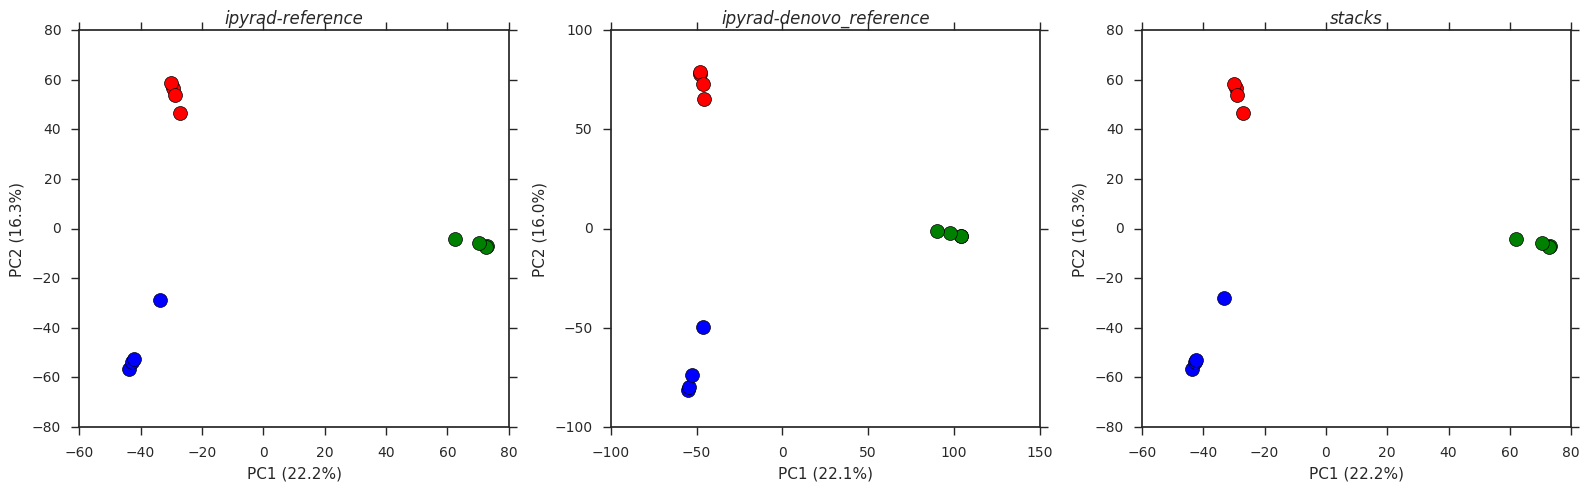

In [111]:
f, axarr = plt.subplots(1, 3, figsize=(16,5), dpi=1000)
for prog, ax in zip(assemblers, axarr):

    coords1, model1 = getPCA(calldata[prog])

    x = coords1[:, 0]
    y = coords1[:, 1]

    ax.scatter(x, y, marker='o')
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))

    for pop in pops.keys():
        flt = np.in1d(np.array(sim_sample_names), pops[pop])
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop], label=pop, markersize=10, mec='k', mew=.5)

    ax.set_title(prog, style="italic")
    ax.axison = True
f.tight_layout()

### Plot pairwise distances for each assembler and each simulated datatype

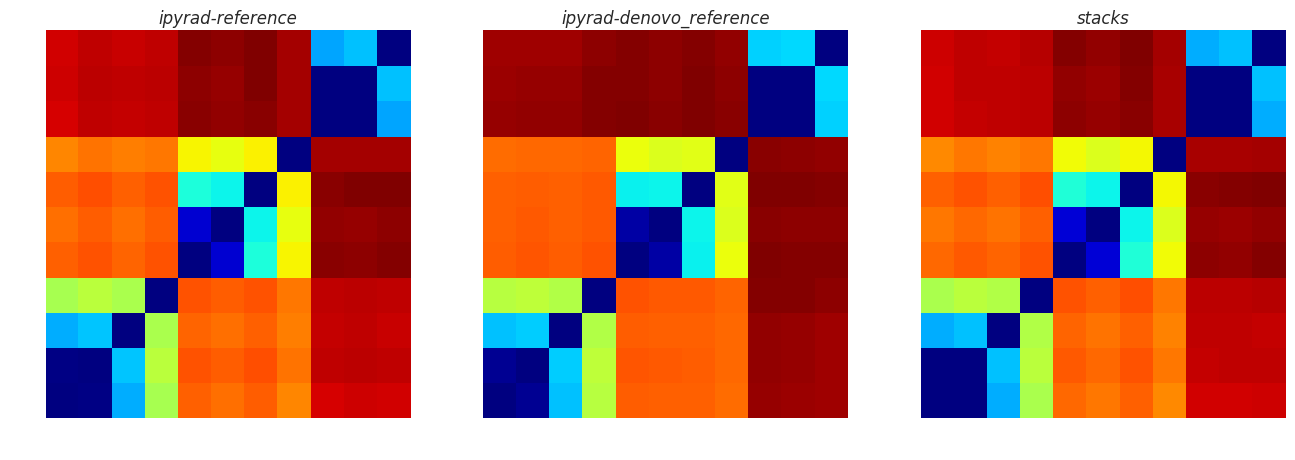

In [112]:
f, axarr = plt.subplots(1, 3, figsize=(16,5), dpi=1000)

for prog, ax in zip(assemblers, axarr):

    ## Calculate pairwise distances
    dist = getDistances(calldata[prog])

    ## Doing it this way works, but allel uses imshow internally which rasterizes the image
    #allel.plot.pairwise_distance(dist, labels=None, ax=ax, colorbar=False)

    ## Create the pcolormesh by hand
    dat = ensure_square(dist)
        
    ## for some reason np.flipud(dat) is chopping off one row of data
    p = ax.pcolormesh(np.arange(0,len(dat[0])), np.arange(0,len(dat[0])), dat,\
    cmap="jet", vmin=np.min(dist), vmax=np.max(dist))
    ## Clip all heatmaps to actual sample size
    p.axes.axis("tight")

    ax.set_title(prog, style="italic")
    ax.axison = False

# Go through and pull in more fine grained results
What we want to know is total number of loci recovered (not just variable loci). First we'll create some dictionaries just like above, but we'll call them *_full_* to indicate that they include monomorphic sites. Because snps don't occur in monomorphic sites kind of by definition, we only really are iterested in the depth across loci and the number of loci recovered per sample.


In [113]:
## Blank the ordered dicts for gathering locus coverage and sample nlocs
sim_full_loc_cov = collections.OrderedDict()
sim_full_sample_nlocs = collections.OrderedDict()

## ipyrad simulated results

In [114]:
assembly_methods = {"ipyrad-reference":"refmap-sim", "ipyrad-denovo_reference":"denovo_ref-sim"}

for name, method in assembly_methods.items():
    print(method)
    simdir = os.path.join(IPYRAD_SIM_DIR, method + "_outfiles/")
    statsfile = simdir + "{}_stats.txt".format(method)
    infile = open(statsfile).readlines()
    sample_coverage = [int(x.strip().split()[1]) for x in infile[20:32]]
    print(sample_coverage)
    print("mean sample coverage - {}\t".format(np.mean(sample_coverage))),
    print("min/max - {}/{}\t".format(np.min(sample_coverage), np.max(sample_coverage)))
    sim_full_sample_nlocs[name] = sample_coverage
    
    nmissing = [int(x.strip().split()[1]) for x in infile[38:50]]
    sim_full_loc_cov[name] = nmissing

## Just look at the ones we care about for ipyrad
print(sim_full_loc_cov.items())
print(sim_full_sample_nlocs.items())

denovo_ref-sim
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
mean sample coverage - 1000.0	min/max - 1000/1000	
refmap-sim
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
mean sample coverage - 500.0	min/max - 500/500	
[('ipyrad-denovo_reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]), ('ipyrad-reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500])]
[('ipyrad-denovo_reference', [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]), ('ipyrad-reference', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500])]


## stacks simulated results

In [115]:
method = "stacks"
simdir = STACKS_SIM_DIR
try:

    lines = open("{}/batch_1.haplotypes.tsv".format(simdir)).readlines()
    cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
    sim_full_loc_cov[method] = [cnts.count(i) for i in range(1,13)]
except Exception as inst:
    print("loc_cov - {} - {}".format(inst, simdir))

try:
    sim_full_sample_nlocs[method] = []
    samp_haps = glob.glob("{}/*matches*".format(simdir))
    for f in samp_haps:
        lines = gzip.open(f).readlines()
        sim_full_sample_nlocs[method].append(len(lines) - 1)
except Exception as inst:
    print("sample_nlocs - {} - {}".format(inst, simdir))

print(sim_full_loc_cov.items())
print(sim_full_sample_nlocs.items())

[('ipyrad-denovo_reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]), ('ipyrad-reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500]), ('stacks', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 997])]
[('ipyrad-denovo_reference', [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]), ('ipyrad-reference', [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]), ('stacks', [1163, 1165, 1162, 1154, 1154, 1154, 1153, 1160, 1144, 1144, 1149, 1135])]


## Plotting simulation results

Mean number of loci recovered per sample.
                        simulated
ipyrad-reference              500
ipyrad-denovo_reference      1000
stacks                    1153.08


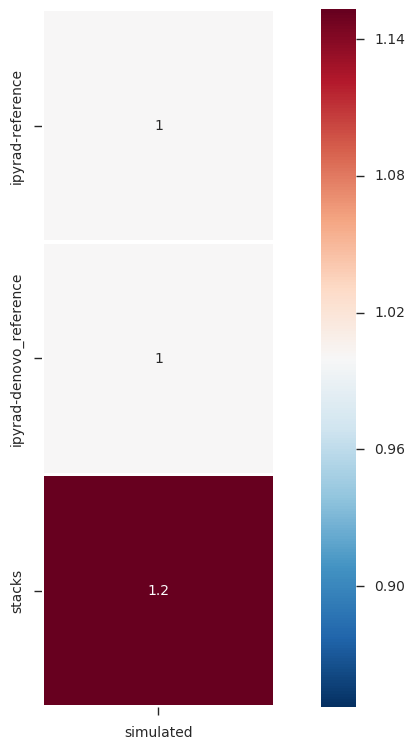

In [116]:
simlevel = ["simulated"]
sim_sample_nlocs_df = pd.DataFrame(index=assemblers, columns=simlevel)

for sim in simlevel:
    for ass in assemblers:
        simstring = ass
        sim_sample_nlocs_df[sim][ass] = np.mean(sim_full_sample_nlocs[simstring])
print("Mean number of loci recovered per sample.")
## Normalize all bins
dat = sim_sample_nlocs_df[sim_sample_nlocs_df.columns].astype(float)
for sim in simlevel:
    scale = 1000
#    if "ipyrad-reference" == sim
    dat[sim] = dat[sim]/scale
    dat[sim]["ipyrad-reference"] *= 2
sns.heatmap(dat, square=True, center=1, linewidths=2, annot=True)
print(sim_sample_nlocs_df)

### Much better! Do the spline plot version of the above plot
It just looks nicer, makes more sense.

__NB__: This is broken for refmap.

ValueError: left cannot be >= right

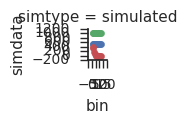

In [60]:
dfsns2 = pd.DataFrame(columns = ["assembler", "simtype", "bin", "simdata"])


for sim in simlevel:
    for ass in assemblers:
        simstring = ass
        ## Normalize values so different sim sizes print the same
        max = 1000.
        
        newdat = sim_full_loc_cov[simstring]
        newdat = [sum(newdat)-sum(newdat[:i-1]) for i in range(1,13)]
        for i, val in enumerate(newdat):
            dfsns2.loc[simstring + "-" + str(i)] = [ass, sim, i+1, val]

g = sns.FacetGrid(dfsns2, col="simtype", hue="assembler", size=1)
g.map(plt.scatter, "bin", "simdata")
g.map(plt.plot, "bin", "simdata").add_legend()
#axs = g.axes
#for ax in axs:
#    ax.set_xlim(0,12.5)

# Empirical Results (Phocoena)
This section is incomplete. See below for empirical and simulated results that are combined.

## Process the vcf output from all the runs
Here we'll pull together all the output vcf files. This takes a few minutes to run.

In [123]:
emp_vcf_dict = {}
emp_vcf_dict["ipyrad-reference"] = os.path.join(IPYRAD_REFMAP_DIR, "refmap-empirical_outfiles/refmap-empirical.vcf")
emp_vcf_dict["ipyrad-denovo_reference"] = os.path.join(IPYRAD_REFMAP_DIR, "denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf")
emp_vcf_dict["stacks"] = os.path.join(STACKS_REFMAP_DIR, "batch_1.vcf")

## Read in vcf for each analysis and pull in coverage/depth stats

[vcfnp] 2016-12-29 22:07:19.464202 :: caching is disabled
[vcfnp] 2016-12-29 22:07:19.464703 :: building array


Doing - ipyrad-denovo_reference
	/home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf
file not found: /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf
Doing - ipyrad-reference
	/home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/refmap-empirical_outfiles/refmap-empirical.vcf
file not found: /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/refmap-empirical_outfiles/refmap-empirical.vcf
Doing - stacks
	/home/iovercast/manuscript-analysis/Phocoena_empirical/stacks/batch_1.vcf


[vcfnp] 2016-12-29 22:07:22.543297 :: caching is disabled
[vcfnp] 2016-12-29 22:07:22.543798 :: building array


global name 'species' is not defined


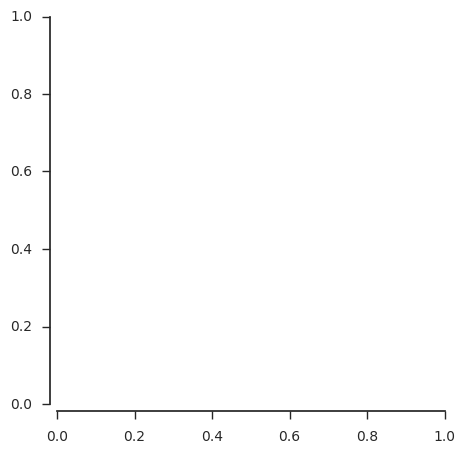

In [124]:
emp_loc_cov = collections.OrderedDict()
emp_snp_cov = collections.OrderedDict()
emp_sample_nsnps = collections.OrderedDict()
emp_sample_nlocs = collections.OrderedDict()
## Try just doing them all the same
for prog, filename in emp_vcf_dict.items():
    try:
        print("Doing - {}".format(prog))
        print("\t{}".format(filename))
        v = vcfnp.variants(filename, dtypes={"CHROM":"a24"}).view(np.recarray)
        c = vcfnp.calldata_2d(filename).view(np.recarray)

        emp_loc_cov[prog] = loci_coverage(v, c, prog)
        emp_snp_cov[prog] = snp_coverage(c)
        emp_sample_nsnps[prog] = sample_nsnps(c)
        emp_sample_nlocs[prog] = sample_nloci(v, c, prog)
        
        plotPCA(c, prog)
        plotPairwiseDistance(c, prog)
    except Exception as inst:
        print(inst)

In [608]:
for i in emp_sample_nlocs:
    print(i),
    print(emp_sample_nlocs[i])

stacks_default [22215, 32074, 25377, 16640, 23557, 17426, 32172, 34354, 31333, 29809, 34792, 24791, 25256]
ddocent_full [34816, 37668, 35523, 25583, 36635, 25751, 38051, 39179, 38946, 38744, 39209, 37612, 37240]
pyrad [22826, 34866, 30179, 19710, 19076, 21977, 36830, 36774, 37212, 29720, 38012, 35350, 31155]
ipyrad [18710, 28396, 24635, 15667, 15301, 17830, 29885, 29492, 30213, 24043, 30671, 29076, 25580]
ddocent_filt [18640, 18904, 18745, 18471, 18713, 18553, 18969, 19050, 19096, 19068, 19086, 19182, 19164]
stacks_ungapped [23103, 35494, 30792, 19377, 19547, 21469, 36663, 36949, 36703, 29789, 37968, 33544, 31931]


## ipyrad Empirical results
First we load in the variant info and call data for all the snps

In [70]:
IPYRAD_EMPIRICAL_OUTPUT=os.path.join(IPYRAD_DIR, "REALDATA/")
IPYRAD_STATS = os.path.join(IPYRAD_EMPIRICAL_OUTPUT, "REALDATA_outfiles/REALDATA_stats.txt")

infile = open(IPYRAD_STATS).readlines()
sample_coverage = [int(x.strip().split()[1]) for x in infile[20:33]]
print(sample_coverage)
print("mean sample coverage - {}".format(np.mean(sample_coverage)))
print("min/max - {}/{}".format(np.min(sample_coverage), np.max(sample_coverage)))

[21163, 31863, 27902, 20852, 17779, 23008, 33289, 33697, 35765, 29184, 35096, 38144, 34746]
mean sample coverage - 29422.1538462
min/max - 17779/38144


Read the biallelic vcf

In [71]:
filename = os.path.join(IPYRAD_EMPIRICAL_OUTPUT, "REALDATA_outfiles/REALDATA.biallelic.vcf")
# filename = vcf_dict["ipyrad"]
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 12:42:26.099077 :: caching is disabled
[vcfnp] 2016-10-12 12:42:26.099836 :: building array
[vcfnp] 2016-10-12 12:42:29.441796 :: caching is disabled
[vcfnp] 2016-10-12 12:42:29.442748 :: building array


### Distribution of snps along loci
Getting variable sites and parsimony informative sites from the vcf is kind of annoying
because all the programs export __slightly__ different formats, so you need to
parse them in slightly different ways. There's a better way to do this for ipyrad
but i figure i'll do it the same way for all of them so it's more clear what's happening.

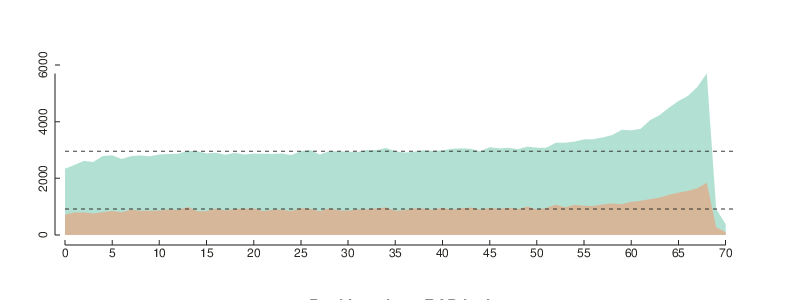

In [72]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["POS"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x) for x in v.POS])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

## stacks empirical results

In [12]:
STACKS_OUTPUT=os.path.join(STACKS_DIR, "REALDATA/")
STACKS_GAP_OUT=os.path.join(STACKS_OUTPUT, "gapped/")
STACKS_UNGAP_OUT=os.path.join(STACKS_OUTPUT, "ungapped/")
STACKS_DEFAULT_OUT=os.path.join(STACKS_OUTPUT, "default/")

#lines = open("SIMsmall/stackf_high/batch_1.haplotypes.tsv").readlines()
#cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
#shigh = [cnts.count(i) for i in range(1,13)]

In [13]:
filename = os.path.join(STACKS_UNGAP_OUT, "batch_1.vcf")
v = vcfnp.variants(filename).view(np.recarray)
c = vcfnp.calldata_2d(filename).view(np.recarray)

[vcfnp] 2016-10-12 10:48:17.512074 :: caching is disabled
[vcfnp] 2016-10-12 10:48:17.512879 :: building array
[vcfnp] 2016-10-12 10:48:25.055213 :: caching is disabled
[vcfnp] 2016-10-12 10:48:25.061273 :: building array


### Distribution of snps along loci

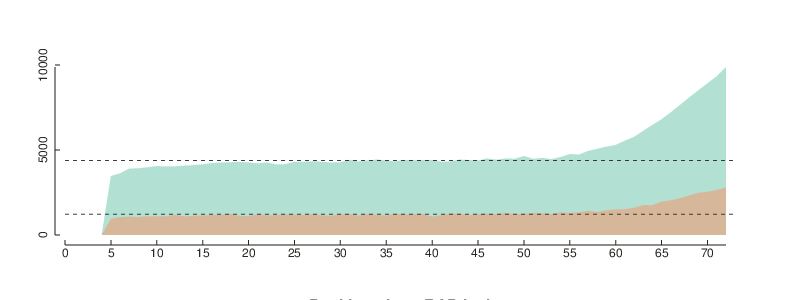

In [14]:
## Get only parsimony informative sites
## Get T/F values for whether each genotype is ref or alt across all samples/loci
is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
## Create a T/F mask for snps that are informative
only_pis = map(lambda x: x < 2, alt_counts)
## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
## Also, compress() the masked array so we only actually see the pis
pis = np.ma.array(np.array(v["ID"]), mask=only_pis).compressed()

## Now have to massage this into the list of counts per site in increasing order 
## of position across the locus
distpis = Counter([int(x.split("_")[1]) for x in pis])
#distpis = [x for x in sorted(counts.items())]

## Getting the distvar is easier
distvar = Counter([int(x.split("_")[1]) for x in v.ID])
#distvar = [x for x in sorted(counts.items())]

canvas, axes = SNP_position_plot(distvar, distpis)

## save fig
#toyplot.html.render(canvas, 'snp_positions.html')

canvas

# Do both simulated and empirical at the same time
Could make the plots prettier

In [129]:
vcf_dict = {}
vcf_dict["ipyrad-reference-sim"] = os.path.join(IPYRAD_SIM_DIR, "refmap-sim_outfiles/refmap-sim.vcf")
vcf_dict["ipyrad-denovo_reference-sim"] = os.path.join(IPYRAD_SIM_DIR, "denovo_ref-sim_outfiles/denovo_ref-sim.vcf")
vcf_dict["stacks-sim"] = os.path.join(STACKS_SIM_DIR, "batch_1.vcf")
vcf_dict["ipyrad-reference-empirical"] = os.path.join(IPYRAD_REFMAP_DIR, "refmap-empirical_outfiles/refmap-empirical.vcf")
vcf_dict["ipyrad-denovo_reference-empirical"] = os.path.join(IPYRAD_REFMAP_DIR, "denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf")
vcf_dict["stacks-empirical"] = os.path.join(STACKS_REFMAP_DIR, "batch_1.vcf")
## Make sure we have all the vcf files
for k, f in vcf_dict.items():
    if os.path.exists(f):
        print("found - {}".format(f))
    else:
        print("not found - {}".format(f))

found - /home/iovercast/manuscript-analysis/Phocoena_empirical/stacks/batch_1.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf
not found - /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/refmap-empirical_outfiles/refmap-empirical.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/refmap-sim_outfiles/refmap-sim.vcf
found - /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_ref-sim_outfiles/denovo_ref-sim.vcf
not found - /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf


In [247]:
import collections
## Load the calldata into a dict so we don't have to keep loading and reloading it
## This can take several minutes for the large empirical datasets
all_calldata = {}
all_vardata = {}

## Dicts for tracking all the stats
loc_cov = collections.OrderedDict()
snp_cov = collections.OrderedDict()
samp_nsnps = collections.OrderedDict()
samp_nlocs = collections.OrderedDict()

for prog, filename in vcf_dict.items():
    try:
        print("Doing - {}\n  {}".format(prog, filename))
        v = vcfnp.variants(filename, verbose=False, dtypes={"CHROM":"a24"}).view(np.recarray)
        c = vcfnp.calldata_2d(filename, verbose=False).view(np.recarray)
        all_calldata[prog] = c
        all_vardata[prog] = v
        
        snp_cov[prog] = snp_coverage(c)
        samp_nsnps[prog] = sample_nsnps(c)
        loc_cov[prog] = loci_coverage(v, c, prog)
        samp_nlocs[prog] = sample_nloci(v, c, prog)
    except Exception as inst:
        print(inst)

Doing - stacks-empirical
  /home/iovercast/manuscript-analysis/Phocoena_empirical/stacks/batch_1.vcf
Doing - stacks-sim
  /home/iovercast/manuscript-analysis/REFMAP_SIM/stacks/batch_1.vcf
Doing - ipyrad-reference-empirical
  /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/refmap-empirical_outfiles/refmap-empirical.vcf
file not found: /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/refmap-empirical_outfiles/refmap-empirical.vcf
Doing - ipyrad-reference-sim
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/refmap-sim_outfiles/refmap-sim.vcf
Doing - ipyrad-denovo_reference-sim
  /home/iovercast/manuscript-analysis/REFMAP_SIM/ipyrad/reference-assembly/denovo_ref-sim_outfiles/denovo_ref-sim.vcf
Doing - ipyrad-denovo_reference-empirical
  /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/denovo_ref-empirical_outfiles/denovo_ref-empirical.vcf
file not found: /home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/denovo_re

In [248]:
for statname, stat in {"loc_cov":loc_cov, "snp_cov":snp_cov,\
             "sample_nsnps":samp_nsnps, "sample_nlocs":samp_nlocs}.items():
    for prog in vcf_dict.keys():
        try:
            print(prog + " " + statname + "\t"),
            print(stat[prog]),
            print(np.mean(stat[prog]))
        except:
            print("No {} stats for {}".format(statname, prog))
    print("------------------------------------------------------")

stacks-empirical sample_nlocs	[36564, 45195, 92008, 88319, 83252, 93109, 83942, 110102, 26729, 68932, 98216, 57176, 91547, 50223, 81625, 78322, 94099, 92146, 104316, 94151, 82414, 81962, 78511, 98960, 87105, 95557, 93372, 65463, 81766, 87529, 91929, 46207, 84925, 92421, 70530, 86883, 79414, 97308, 85021, 98059, 96071, 97110, 37502, 97311] 81438.7045455
stacks-sim sample_nlocs	[994, 993, 994, 993, 994, 994, 994, 994, 994, 994, 994, 994] 993.833333333
ipyrad-reference-empirical sample_nlocs	No sample_nlocs stats for ipyrad-reference-empirical
ipyrad-reference-sim sample_nlocs	[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500] 500.0
ipyrad-denovo_reference-sim sample_nlocs	[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000] 1000.0
ipyrad-denovo_reference-empirical sample_nlocs	No sample_nlocs stats for ipyrad-denovo_reference-empirical
------------------------------------------------------
stacks-empirical sample_nsnps	[61779, 75863, 147395, 142916, 137488, 

### Some magic to get samples and populations properly grouped and colored for pretty PCA plots
There has got to be a better way to do this for the empirical at least. It seems super ghetto, but it works.

In [229]:
## sim
pop1 = ["1A_0", "1B_0", "1C_0", "1D_0"]
pop2 = ["2E_0", "2F_0", "2G_0", "2H_0"]
pop3 = ["3I_0", "3J_0", "3K_0", "3L_0"]
sim_sample_names = pop1 + pop2 + pop3
sim_pops = {"pop1":pop1, "pop2":pop2, "pop3":pop3}
sim_pop_colors = {"pop1":"r", "pop2":"b", "pop3":"g"}

## empirical
emp_pops = {}
emp_sample_names = []
popfile = os.path.join(STACKS_REFMAP_DIR, "popmap.txt")
with open(popfile) as infile:
    lines = [l.strip().split() for l in infile.readlines()]
    emp_sample_names = [x[0] for x in lines]
    pops = set([x[1] for x in lines])
    for pop in pops: emp_pops[pop] = []
    for line in lines:
        p = line[1]
        s = line[0]
        emp_pops[p].append(s)
emp_pop_colors = {k:v for (k,v) in zip(emp_pops, list(matplotlib.colors.cnames))}

('ipyrad-reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd33828d0>)
('ipyrad-denovo_reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd346de10>)
('stacks-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aac0a3ac2d0>)
('ipyrad-reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aab665cb6d0>)
('ipyrad-denovo_reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd33f9a10>)
('stacks-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd3c75c90>)


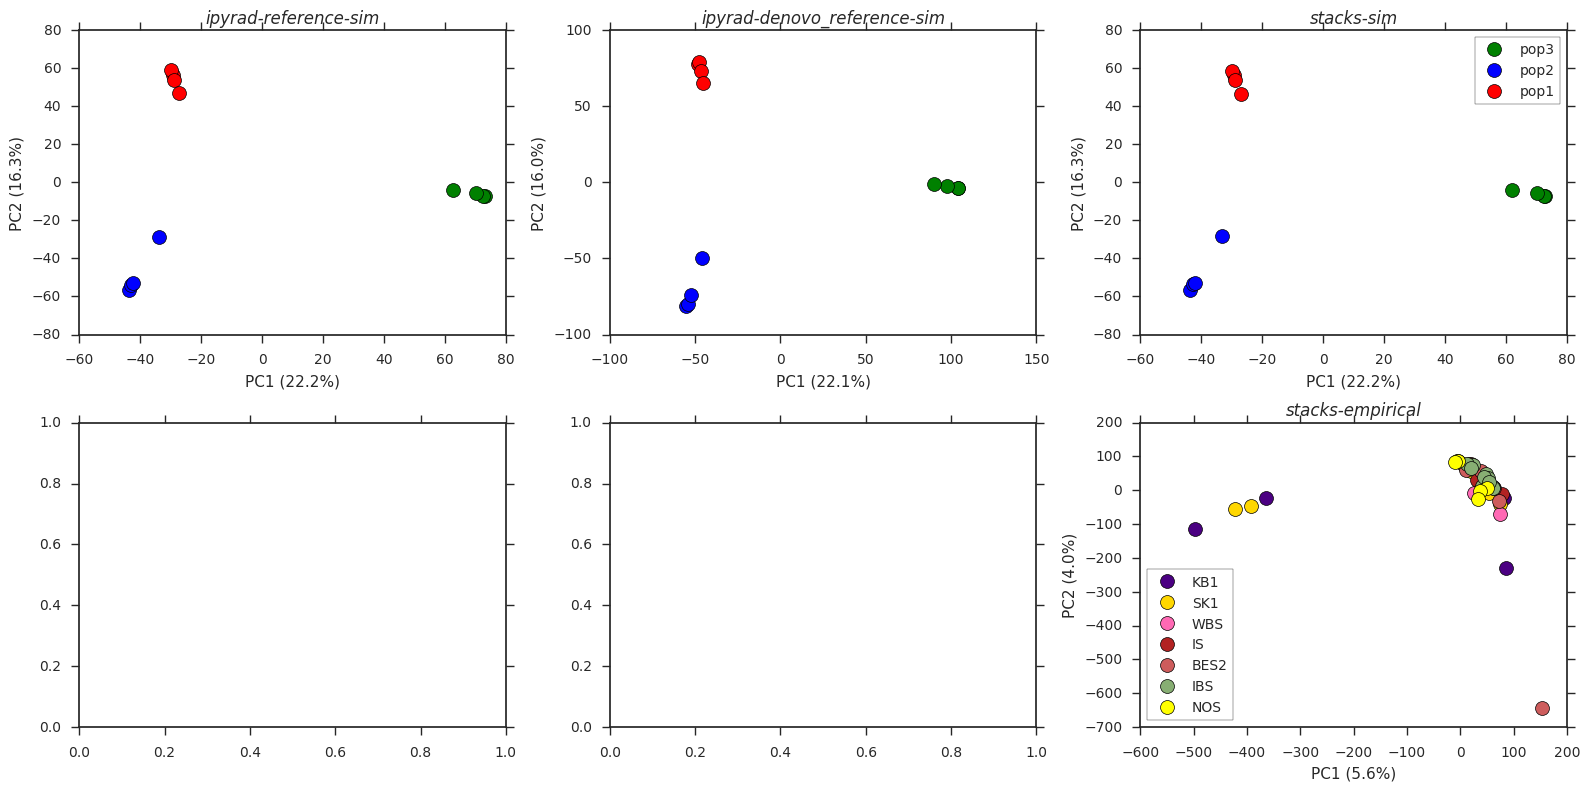

In [256]:
f, axarr = plt.subplots(2, 3, figsize=(16,8), dpi=1000)
## Make a list out of the axes
axarr = [a for b in axarr for a in b]
## Set them in order so the plot looks nice.
progs = ["ipyrad-reference-sim", "ipyrad-denovo_reference-sim", "stacks-sim",\
         "ipyrad-reference-empirical", "ipyrad-denovo_reference-empirical", "stacks-empirical"]

for prog, ax in zip(progs, axarr):
    print(prog, ax)
    if "empirical" in prog:
        pop_colors = emp_pop_colors
        pops = emp_pops
        sample_names = emp_sample_names
    else:
        pop_colors = sim_pop_colors
        pops = sim_pops
        sample_names = sim_sample_names
    ## Don't die if some of the runs aren't complete
    try:
        coords1, model1 = getPCA(all_calldata[prog])
    except:
        continue
        
    x = coords1[:, 0]
    y = coords1[:, 1]

    ax.scatter(x, y, marker='o')
    ax.set_xlabel('PC%s (%.1f%%)' % (1, model1.explained_variance_ratio_[0]*100))
    ax.set_ylabel('PC%s (%.1f%%)' % (2, model1.explained_variance_ratio_[1]*100))

    for pop in pops.keys():
        flt = np.in1d(np.array(sample_names), pops[pop])
        ax.plot(x[flt], y[flt], marker='o', linestyle=' ', color=pop_colors[pop], label=pop, markersize=10, mec='k', mew=.5)

    ax.set_title(prog, style="italic")
    ax.axison = True

axarr[2].legend(frameon=True)
axarr[5].legend(loc='lower left', frameon=True)

f.tight_layout()

('ipyrad-reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd372a650>)
('ipyrad-denovo_reference-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd382a2d0>)
('stacks-sim', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd38ac650>)
('ipyrad-reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd390f590>)
('ipyrad-denovo_reference-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd3991a10>)
('stacks-empirical', <matplotlib.axes._subplots.AxesSubplot object at 0x2aabd8f6f410>)


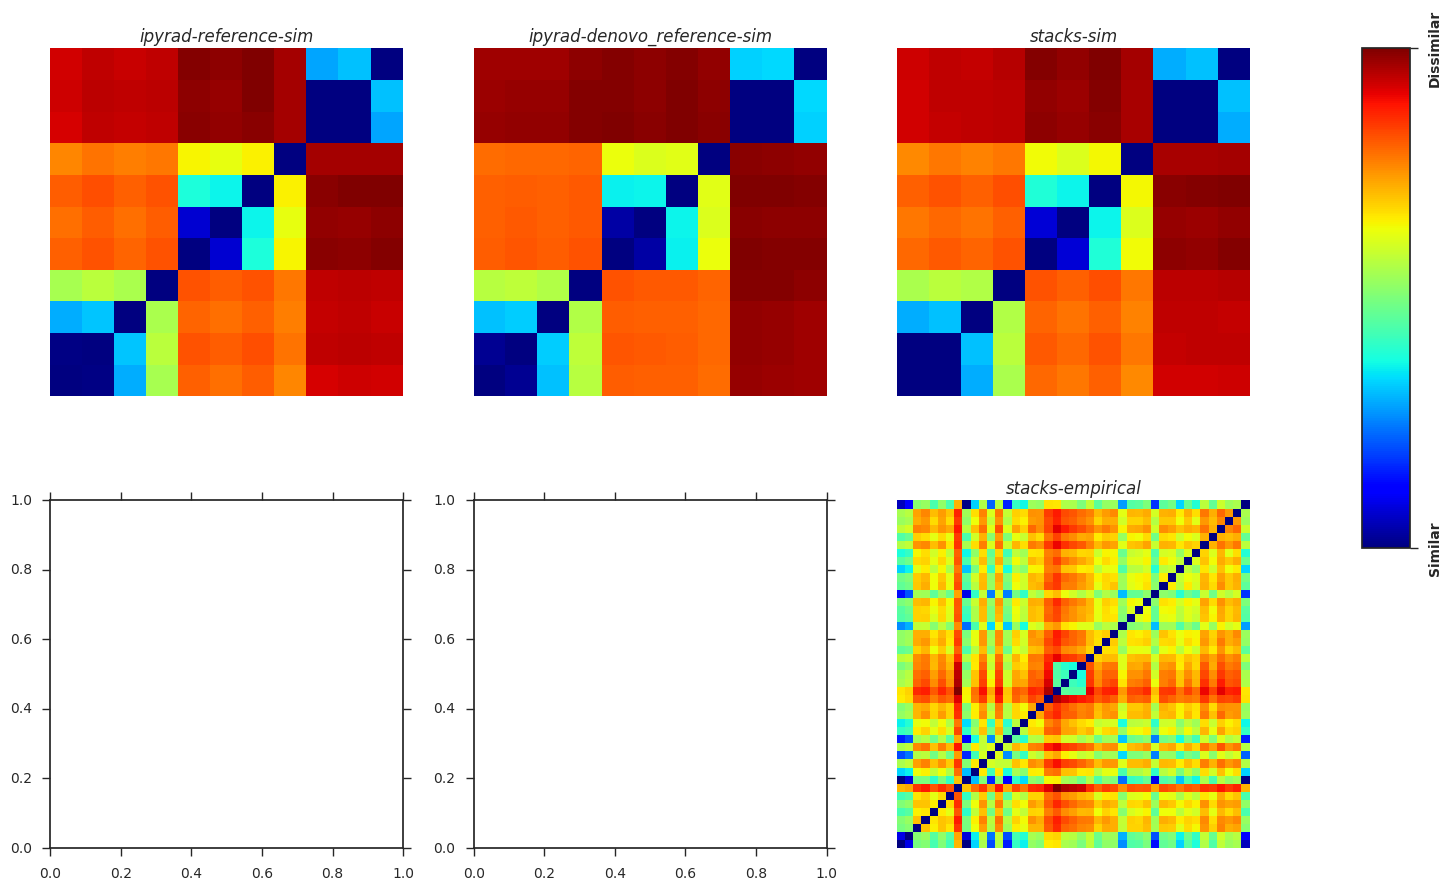

In [258]:
f, axarr = plt.subplots(2, 3, figsize=(16,10), dpi=1000)
axarr = [a for b in axarr for a in b]
## Set them in order so the plot looks nice.
progs = ["ipyrad-reference-sim", "ipyrad-denovo_reference-sim", "stacks-sim",\
         "ipyrad-reference-empirical", "ipyrad-denovo_reference-empirical", "stacks-empirical"]

for prog, ax in zip(progs, axarr):
    print(prog, ax)
    try:
        ## Calculate pairwise distances
        dist = getDistances(all_calldata[prog])
    except:
        continue

    ## Create the pcolormesh by hand
    dat = ensure_square(dist)
        
    ## for some reason np.flipud(dat) is chopping off one row of data
    p = ax.pcolormesh(np.arange(0,len(dat[0])), np.arange(0,len(dat[0])), dat,\
    cmap="jet", vmin=np.min(dist), vmax=np.max(dist))
    ## Clip all heatmaps to actual sample size
    p.axes.axis("tight")

    ax.set_title(prog, style="italic")
    ax.axison = False

## Adjust margins to make room for the colorbar
plt.subplots_adjust(left=0.05, bottom=0.1, right=0.8, top=0.9, wspace=0.2, hspace=0.3)

## Add the colorbar
cax = f.add_axes([0.87, 0.4, 0.03, 0.5])
cb1 = matplotlib.colorbar.ColorbarBase(cax, cmap="jet", orientation="vertical", ticks=([0,1]))
cb1.ax.set_yticklabels(['Similar', "Dissimilar"], weight="bold", rotation="vertical")

In [251]:
## Blank the ordered dicts for gathering locus coverage and sample nlocs
all_full_loc_cov = collections.OrderedDict()
all_full_sample_nlocs = collections.OrderedDict()

## Mapping between 'pretty names' and directory names
assembly_methods = {"ipyrad-reference":"refmap-sim", "ipyrad-denovo_reference":"denovo_ref-sim",\
                    "stacks-sim":"stacks-sim", "ipyrad-reference-empirical":"refmap-empirical",\
                    "ipyrad-denovo_reference-empirical":"denovo_ref-empirical",\
                    "stacks-empirical":"stacks-empirical"}

for name, method in assembly_methods.items():
    if "ipyrad" in name:
        outdir = IPYRAD_SIM_DIR
        firstsamp = 20
        lastsamp = 32
        if "empirical" in name:
            outdir = IPYRAD_REFMAP_DIR
            firstsamp = 40 #fixme
            lastsamp = 84 # fixme
        try:
            simdir = os.path.join(outdir, method + "_outfiles/")
            statsfile = simdir + "{}_stats.txt".format(method)
            infile = open(statsfile).readlines()
            sample_coverage = [int(x.strip().split()[1]) for x in infile[firstsamp:lastsamp]]
            print(sample_coverage)
            print("mean sample coverage - {}\t".format(np.mean(sample_coverage))),
            print("min/max - {}/{}\t".format(np.min(sample_coverage), np.max(sample_coverage)))
            all_full_sample_nlocs[name] = sample_coverage

            nmissing = [int(x.strip().split()[1]) for x in infile[38:50]]
            all_full_loc_cov[name] = nmissing
        except Exception as inst:
            print(inst)
    else:
        outdir = STACKS_SIM_DIR
        if "empirical" in name:
            outdir = STACKS_REFMAP_DIR
        try:

            lines = open("{}/batch_1.haplotypes.tsv".format(outdir)).readlines()
            cnts = [int(field.strip().split("\t")[1]) for field in lines[1:]]
            all_full_loc_cov[method] = [cnts.count(i) for i in range(1,13)]
        except Exception as inst:
            print("loc_cov - {} - {}".format(inst, simdir))

        try:
            all_full_sample_nlocs[method] = []
            samp_haps = glob.glob("{}/*matches*".format(outdir))
            for f in samp_haps:
                lines = gzip.open(f).readlines()
                all_full_sample_nlocs[method].append(len(lines) - 1)
        except Exception as inst:
            print("sample_nlocs - {} - {}".format(inst, outdir))

print(all_full_loc_cov.items())
print(all_full_sample_nlocs.items())

[Errno 2] No such file or directory: '/home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/refmap-empirical_outfiles/refmap-empirical_stats.txt'
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
mean sample coverage - 1000.0	min/max - 1000/1000	
[Errno 2] No such file or directory: '/home/iovercast/manuscript-analysis/Phocoena_empirical/ipyrad/denovo_ref-empirical_outfiles/denovo_ref-empirical_stats.txt'
[500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
mean sample coverage - 500.0	min/max - 500/500	
[('stacks-empirical', [44367, 19212, 12649, 9571, 7961, 6694, 5997, 5625, 5210, 5136, 4765, 4653]), ('ipyrad-denovo_reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000]), ('stacks-sim', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 997]), ('ipyrad-reference', [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 500])]
[('stacks-empirical', [321973, 346480, 312450, 353761, 406143, 333570, 294514, 327705, 342850, 335347, 351034, 330976, 279661, 345149, 331976, 216198, 307288, 3278

# TESTING - Everything below here is crap

In [ ]:
for prog in progs:
#for prog in ["ipyrad-reference-sim"]:
    print("Doing {}".format(prog))
    try:
        c = all_calldata[prog]
        v = all_vardata[prog]
    except:
        print("Failed to load for {}".format(prog))
        continue
    ## Get only parsimony informative sites
    ## Get T/F values for whether each genotype is ref or alt across all samples/loci
    is_alt_allele = map(lambda x: map(lambda y: 1 in y, x), c["genotype"])
    ## Count the number of alt alleles per snp (we only want to retain when #alt > 1)
    alt_counts = map(lambda x: np.count_nonzero(x), is_alt_allele)
    ## Create a T/F mask for snps that are informative
    only_pis = map(lambda x: x < 2, alt_counts)
    ## Apply the mask to the variant array so we can pull out the position of each snp w/in each locus
    ## Also, compress() the masked array so we only actually see the pis
    pis = np.ma.array(np.array(v["POS"]), mask=only_pis).compressed()

    ## Now have to massage this into the list of counts per site in increasing order 
    ## of position across the locus
    distpis = Counter([int(x) for x in pis])
    #distpis = [x for x in sorted(counts.items())]

    ## Getting the distvar is easier
    distvar = Counter([int(x) for x in v.POS])
    #distvar = [x for x in sorted(counts.items())]

    canvas, axes = SNP_position_plot(prog, distvar, distpis)

    ## save fig
    #toyplot.html.render(canvas, 'snp_positions.html')

    canvas

Doing ipyrad-reference-sim
Doing ipyrad-denovo_reference-sim
Doing stacks-sim
Doing ipyrad-reference-empirical
Doing ipyrad-denovo_reference-empirical
Doing stacks-empirical


<polygon points="65.0,235.0 68.602150537634415,235.0 72.204301075268816,235.0 75.806451612903231,235.0 79.408602150537632,235.0 83.010752688172047,235.0 86.612903225806448,235.0 90.215053763440864,235.0 93.817204301075265,235.0 97.41935483870968,235.0 101.02150537634409,235.0 104.6236559139785,235.0 108.2258064516129,235.0 111.82795698924731,235.0 115.43010752688173,235.0 119.03225806451613,235.0 122.63440860215054,235.0 126.23655913978493,235.0 129.83870967741936,235.0 133.44086021505376,235.0 137.04301075268816,235.0 140.64516129032259,235.0 144.24731182795699,235.0 147.84946236559139,235.0 151.45161290322579,235.0 155.05376344086022,235.0 158.65591397849462,235.0 162.25806451612902,235.0 165.86021505376345,235.0 169.46236559139786,235.0 173.06451612903226,235.0 176.66666666666669,235.0 180.26881720430109,235.0 183.87096774193549,235.0 187.47311827956989,235.0 191.07526881720429,235.0 194.67741935483869,235.0 198.27956989247309,235.0 201.88172043010752,235.0 205.48387096774195,235.0 209.08602150537632,235.0 212.68817204301075,235.0 216.29032258064515,235.0 219.89247311827955,235.0 223.49462365591398,235.0 227.09677419354841,235.0 230.69892473118279,235.0 234.30107526881721,235.0 237.90322580645159,235.0 241.50537634408602,235.0 245.10752688172042,235.0 248.70967741935482,235.0 252.31182795698925,235.0 255.91397849462368,235.0 259.51612903225811,235.0 263.11827956989248,235.0 266.72043010752691,235.0 270.32258064516128,235.0 273.92473118279571,235.0 277.52688172043014,235.0 281.12903225806451,235.0 284.73118279569894,235.0 288.33333333333331,235.0 291.93548387096774,235.0 295.53763440860217,235.0 299.13978494623655,235.0 302.74193548387098,235.0 306.34408602150535,235.0 309.94623655913978,235.0 313.54838709677421,235.0 317.15053763440864,235.0 320.75268817204301,235.0 324.35483870967738,235.0 327.95698924731181,235.0 331.55913978494618,235.0 335.16129032258067,235.0 338.76344086021504,235.0 342.36559139784947,235.0 345.9677419354839,235.0 349.56989247311827,235.0 353.1720430107527,235.0 356.77419354838707,235.0 360.3763440860215,235.0 363.97849462365593,235.0 367.58064516129031,235.0 371.18279569892474,235.0 374.78494623655911,235.0 378.38709677419354,235.0 381.98924731182797,235.0 385.59139784946234,235.0 389.19354838709683,235.0 392.7956989247312,235.0 396.39784946236563,235.0 400.0,235.0 403.60215053763437,235.0 407.2043010752688,235.0 410.80645161290317,235.0 414.40860215053766,235.0 418.01075268817203,235.0 421.61290322580646,235.0 425.21505376344084,235.0 428.81720430107521,235.0 432.41935483870964,235.0 436.02150537634407,235.0 439.6236559139785,235.0 443.22580645161293,235.0 446.82795698924735,235.0 450.43010752688178,235.0 454.03225806451616,235.0 457.63440860215053,235.0 461.23655913978496,235.0 464.83870967741933,235.0 468.44086021505382,235.0 472.04301075268819,235.0 475.64516129032262,235.0 479.24731182795699,235.0 482.84946236559136,235.0 486.45161290322579,235.0 490.05376344086022,235.0 493.65591397849465,235.0 497.25806451612902,235.0 500.8602150537634,235.0 504.46236559139783,235.0 508.0645161290322,235.0 511.66666666666669,235.0 515.26881720430106,235.0 518.87096774193549,235.0 522.4731182795698,235.0 526.07526881720435,235.0 529.67741935483878,235.0 533.27956989247321,235.0 536.88172043010763,235.0 540.48387096774195,235.0 544.08602150537638,235.0 547.6881720430107,235.0 551.29032258064524,235.0 554.89247311827955,235.0 558.49462365591398,235.0 562.09677419354841,235.0 565.69892473118273,235.0 569.30107526881727,235.0 572.90322580645159,235.0 576.50537634408602,235.0 580.10752688172045,235.0 583.70967741935476,235.0 587.3118279569893,235.0 590.91397849462362,235.0 594.51612903225805,235.0 598.11827956989237,235.0 601.72043010752679,235.0 605.32258064516134,235.0 608.92473118279565,235.0 612.52688172043008,235.0 616.12903225806451,235.0 619.73118279569894,235.0 623.33333333333337,235.0 626.9354838709678,235.0 630.53763440860212,235.0 634.13978494623655,235.0 637.74193548387098,235.0 641.3440860215054,235.0 6

<polygon points="65.0,235.0 68.602150537634415,235.0 72.204301075268816,235.0 75.806451612903231,235.0 79.408602150537632,235.0 83.010752688172047,235.0 86.612903225806448,235.0 90.215053763440864,235.0 93.817204301075265,235.0 97.41935483870968,235.0 101.02150537634409,235.0 104.6236559139785,235.0 108.2258064516129,235.0 111.82795698924731,235.0 115.43010752688173,235.0 119.03225806451613,235.0 122.63440860215054,235.0 126.23655913978493,235.0 129.83870967741936,235.0 133.44086021505376,235.0 137.04301075268816,235.0 140.64516129032259,235.0 144.24731182795699,235.0 147.84946236559139,235.0 151.45161290322579,235.0 155.05376344086022,235.0 158.65591397849462,235.0 162.25806451612902,235.0 165.86021505376345,235.0 169.46236559139786,235.0 173.06451612903226,235.0 176.66666666666669,235.0 180.26881720430109,235.0 183.87096774193549,235.0 187.47311827956989,235.0 191.07526881720429,235.0 194.67741935483869,235.0 198.27956989247309,235.0 201.88172043010752,235.0 205.48387096774195,235.0 209.08602150537632,235.0 212.68817204301075,235.0 216.29032258064515,235.0 219.89247311827955,235.0 223.49462365591398,235.0 227.09677419354841,235.0 230.69892473118279,235.0 234.30107526881721,235.0 237.90322580645159,235.0 241.50537634408602,235.0 245.10752688172042,235.0 248.70967741935482,235.0 252.31182795698925,235.0 255.91397849462368,235.0 259.51612903225811,235.0 263.11827956989248,235.0 266.72043010752691,235.0 270.32258064516128,235.0 273.92473118279571,235.0 277.52688172043014,235.0 281.12903225806451,235.0 284.73118279569894,235.0 288.33333333333331,235.0 291.93548387096774,235.0 295.53763440860217,235.0 299.13978494623655,235.0 302.74193548387098,235.0 306.34408602150535,235.0 309.94623655913978,235.0 313.54838709677421,235.0 317.15053763440864,235.0 320.75268817204301,235.0 324.35483870967738,235.0 327.95698924731181,235.0 331.55913978494618,235.0 335.16129032258067,235.0 338.76344086021504,235.0 342.36559139784947,235.0 345.9677419354839,235.0 349.56989247311827,235.0 353.1720430107527,235.0 356.77419354838707,235.0 360.3763440860215,235.0 363.97849462365593,235.0 367.58064516129031,235.0 371.18279569892474,235.0 374.78494623655911,235.0 378.38709677419354,235.0 381.98924731182797,235.0 385.59139784946234,235.0 389.19354838709683,235.0 392.7956989247312,235.0 396.39784946236563,235.0 400.0,235.0 403.60215053763437,235.0 407.2043010752688,235.0 410.80645161290317,235.0 414.40860215053766,235.0 418.01075268817203,235.0 421.61290322580646,235.0 425.21505376344084,235.0 428.81720430107521,235.0 432.41935483870964,235.0 436.02150537634407,235.0 439.6236559139785,235.0 443.22580645161293,235.0 446.82795698924735,235.0 450.43010752688178,235.0 454.03225806451616,235.0 457.63440860215053,235.0 461.23655913978496,235.0 464.83870967741933,235.0 468.44086021505382,235.0 472.04301075268819,235.0 475.64516129032262,235.0 479.24731182795699,235.0 482.84946236559136,235.0 486.45161290322579,235.0 490.05376344086022,235.0 493.65591397849465,235.0 497.25806451612902,235.0 500.8602150537634,235.0 504.46236559139783,235.0 508.0645161290322,235.0 511.66666666666669,235.0 515.26881720430106,235.0 518.87096774193549,235.0 522.4731182795698,235.0 526.07526881720435,235.0 529.67741935483878,235.0 533.27956989247321,235.0 536.88172043010763,235.0 540.48387096774195,235.0 544.08602150537638,235.0 547.6881720430107,235.0 551.29032258064524,235.0 554.89247311827955,235.0 558.49462365591398,235.0 562.09677419354841,235.0 565.69892473118273,235.0 569.30107526881727,235.0 572.90322580645159,235.0 576.50537634408602,235.0 580.10752688172045,235.0 583.70967741935476,235.0 587.3118279569893,235.0 590.91397849462362,235.0 594.51612903225805,235.0 598.11827956989237,235.0 601.72043010752679,235.0 605.32258064516134,235.0 608.92473118279565,235.0 612.52688172043008,235.0 616.12903225806451,235.0 619.73118279569894,235.0 623.33333333333337,235.0 626.9354838709678,235.0 630.53763440860212,235.0 634.13978494623655,235.0 637.74193548387098,235.0 641.3440860215054,235.0 6